Python/MATLAB for Physics

Adam Watts

In [63]:
%reset -f

<img src="HW_3_1.png" width=600px />

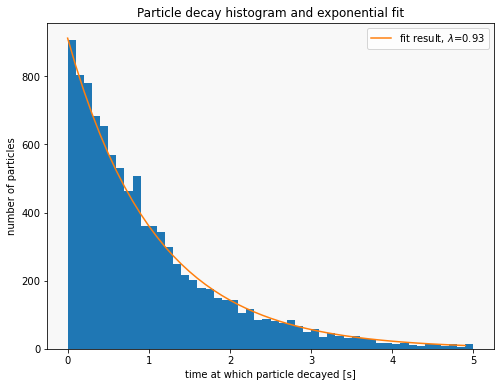

In [74]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

xnum = 10000

# N represents the number of particles that have decayed at each time step
N = np.zeros(xnum)

tstep = 0.01
lam = 1

# Initialize t to the first time step
t=tstep

# Loop through successive time steps
while np.sum(N==0) > 0: # While there are still un-decayed particles
  # Loop through every particle
  for i in range(xnum):
    # If P(dt) ~ -lam*tstep, i.e. probability of decay, is greater than a random number in interval (0,1),
    # consider that particle decayed, add the timestep at which it decayed to N.
    if (np.random.uniform() < tstep*lam and N[i] == 0):
      N[i] = t
  
  t += tstep

nbins = 50
xmax= 5
# hist returns:
# hy; array values of the histogram.
# hx; bin edges
hy,hx = np.histogram(N,bins=nbins,range=(0,xmax))

# Bin edges array is one more element than bin centers.
# Just use the bin centers.
hx = hx[0:nbins]

def exponential(x, A, lam):
  return A*np.exp(-x*lam)

popt, _ = curve_fit(exponential, hx, hy, sigma =1/np.sqrt(hy))

plt.figure(figsize=(8,6))
plt.title('Particle decay histogram and exponential fit')
plt.hist(N,bins=nbins,range=(0,xmax))
plt.plot(hx,exponential(hx,popt[0],popt[1]), label='fit result, $\lambda$=%.2f'%(popt[1]))
plt.xlabel('time at which particle decayed [s]')
plt.ylabel('number of particles')
plt.legend()
plt.gca().set_facecolor('#F8F8F8')

---

<img src="HW_3_2.png" width=600px />

In [77]:
#%reset -f

import numpy as np
import sys
import csv
import os
from scipy.optimize import minimize

def TWISSobj(fparam):
  # I want this function to write to my progress arrays, but I don't want to "return" that data,
  # since the optimizer tries to minimize the return result. I'll call "global" on the progress arrays
  # so this function can write to them.
  global Bx_array
  global ax_array
  global By_array
  global ay_array
  global error_array

  # run with values
  cmdstr = 'python beta_match.py ' + str(fparam[0]) + ' ' + str(fparam[1]) + ' ' + str(fparam[2]) + ' ' + str(fparam[3])
  os.system(cmdstr)
  fparam_out = np.zeros(4)
  # read in outputs
  with open('betas_out') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=' ')
    for row in csv_reader:
      if len(row) > 0:
        fparam_out[0] = float(row[0])
        fparam_out[1] = float(row[1])
        fparam_out[2] = float(row[2])
        fparam_out[3] = float(row[3])

  # produce objective
  err = (fparam_out[0]-fparam[0])**2 + (fparam_out[1]-fparam[1])**2 + (fparam_out[2]-fparam[2])**2 + (fparam_out[3]-fparam[3])**2
   # Write result of this try to the monitoring arrays for later plotting
   # Note that appending to a list is very slow; I'm just doing this for illustrative purposes
  Bx_array.append(fparam_out[0])
  ax_array.append(fparam_out[1])
  By_array.append(fparam_out[2])
  ay_array.append(fparam_out[3])
  error_array.append(err)

  return err

 

# Initialize arrays to put results of each optimizer "try" so we can plot its progress
max_iterations = 100
Bx_array = []
ax_array = []
By_array = []
ay_array = []
error_array = []

Bx0 = 10.0
ax0 = 0.0
By0 = 1.0
ay0 = 0.0
param = [Bx0, ax0, By0, ay0]

Bx_bounds = (0.0, 50.0)
ax_bounds = (-25.0, 25.0)
By_bounds = (0.0, 50.0)
ay_bounds = (-25.0, 25.0)
bnds = (Bx_bounds, ax_bounds, By_bounds, ay_bounds)

res = minimize(TWISSobj, param, method='L-BFGS-B', bounds=bnds, options={'disp': True, 'maxiter': max_iterations})

print("Final Result:")
Bx = res.x[0]
ax = res.x[1]
By = res.x[2]
ay = res.x[3]
print(res)

Final Result:
      fun: 6.651876309184467e-10
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.59510040e-05,  1.06390714e-04,  9.54801138e-05, -2.79662529e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 160
      nit: 24
     njev: 32
   status: 0
  success: True
        x: array([ 8.1544478 , -3.26177759,  0.67523599,  0.27008722])


I ended up having luck with the <a href="https://en.wikipedia.org/wiki/Limited-memory_BFGS#L-BFGS-B">L-BFGS method (bounded, so L-BFGS-B)</a>: 

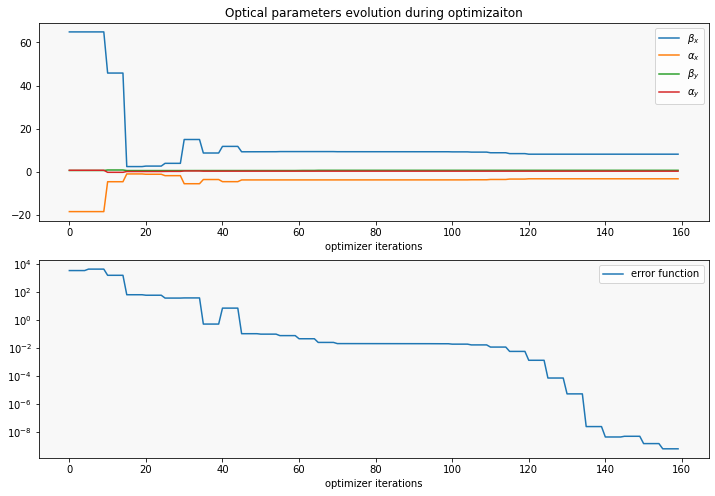

In [87]:
# Plot the progress of the algorithm
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.title('Optical parameters evolution during optimizaiton')
plt.plot(Bx_array, label=r"$\beta_x$")
plt.plot(ax_array, label=r"$\alpha_x$")
plt.plot(By_array, label=r"$\beta_y$")
plt.plot(ay_array, label=r"$\alpha_y$")
plt.legend()
plt.xlabel('optimizer iterations')
plt.gca().set_facecolor('#F8F8F8')

plt.subplot(212)
plt.plot(error_array, label="error function")
plt.gca().set_yscale('log')
plt.legend()
plt.xlabel('optimizer iterations')
plt.gca().set_facecolor('#F8F8F8')